In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

import scipy.io
import sklearn as sk
import matplotlib.pyplot as plt
import itertools
import random

from numba import cuda
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [11]:
seed = np.random.seed(777)

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    
  try:
      
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      
  except RuntimeError as e:
      
    print(e)
    
class MyModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):

    def __init__(self, *args, **kwargs):
        super(MyModelCheckpoint, self).__init__(*args, **kwargs)

    # redefine the save so it only activates after 100 epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch >= 1: super(MyModelCheckpoint, self).on_epoch_end(epoch, logs)

In [12]:
# 모델 메소드 train_step, test_step, compile() 오버라이딩

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student
        
    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        
        1) 옵티마이저 : Student 가중치를 위한 Keras 옵티마이저
        2) 메트릭 : 평가를 위한 Keras 메트릭
        3) student_loss_fn : Student Model의 예측값과 실제값 차이에 대한 손실 함수
        4) distillation_loss_fn : Soft Student Model 의 예측과 Soft Teacher Model의 예측 차이에 대한 손실 함수
        5) alpha : student_loss_fn과 1-alpha to distillation_loss_fn에 대한 가중치
        6) temperature : 확률 분포를 softening 하기 위한 Temperature
        """
        
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature
        
    def train_step(self, data):
        # Unpack data
        x, y = data
        
        # Forward pass of teacher(교사의 Forward Pass)
        teacher_predictions = self.teacher(x, training=False)
        
        with tf.GradientTape() as tape:
            # Forward pass of student (학생의 Forward Pass)
            student_predictions = self.student(x, training=True)
            
            # Compute losses (Losses 계산)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
            
        # Compute gradients (Gradients 계산)
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # Update weights (가중치 업데이트)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update the metrics configured in 'compile()'. (컴파일 안에서 메트릭 업데이트)
        self.compiled_metrics.update_state(y, student_predictions)
        
        # Return a dict of performance(퍼포먼스 dictionary 리턴)
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results
        
    def test_step(self, data):
        # Unpack the data(데이터 언패킹)
        x, y = data

        # Compute predictions(예측 수행)
        y_prediction = self.student(x, training=False)

        # Calculate the loss(loss 계산)
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.(메트릭 업데이트)
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance(퍼포먼스 dictionary 리턴)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [13]:
train_data = scipy.io.loadmat('../../datas/160hz/train_5day_160hz.mat', squeeze_me=True)['data']
test_data = scipy.io.loadmat('../../datas/160hz/test_6day_160hz(2).mat', squeeze_me=True)['data']

# sub 수
sub_cnt = train_data.shape[0]

# 3sec 데이터 크기
data_size = 480

# 1명당 3초 데이터 개수
train_data_cnt = 1052
test_data_cnt = 211

# 3sec 480(= 160*3) 크기로 데이터 길이 설정
train_cut_size = 504960 # 480*1052 = 504960
test_cut_size = 101280 # 480*211 = 101280

# 3sec 데이터 길이 자르기
# train: 504,960 / test: 101,280
train_data = train_data[:,0:train_cut_size,:]
test_data = test_data[:,0:test_cut_size,:]

# flatten(): 3D -> 1D / reshape(-1,1): -1 마지막 인덱스
train_flatten = train_data.flatten().reshape(-1,1)
test_flatten = test_data.flatten().reshape(-1,1)

# StandardScaler(): train에 맞춰 표준화
data_scaler = StandardScaler()
    
data_scaler.fit(train_flatten)
train_scaler = data_scaler.transform(train_flatten)
test_scaler = data_scaler.transform(test_flatten)
    
# train, test 데이터 reshape
train_data = train_scaler.reshape(train_data_cnt * sub_cnt, data_size, 2) 
test_data = test_scaler.reshape(test_data_cnt * sub_cnt, data_size, 2)

#train data를 sub:other=1:1로 만들기 위해서 각 sub 추출
train_data_each = []
for i in range(sub_cnt):
    train_data_each.insert(i, train_data[i*train_data_cnt:(i+1)*train_data_cnt, :, :])
print(np.shape(train_data_each))

#test data를 sub:other=1:3로 만들기 위해서 각 sub 추출
test_data_each = []
for i in range(sub_cnt):
    test_data_each.insert(i, test_data[i*test_data_cnt:(i+1)*test_data_cnt, :, :])
print(np.shape(test_data_each))

# sub number
sub_num = 9

#1 to 3 비율로 설정
ratio = 3

train_data_n = train_data_each[sub_num]
test_data_n = test_data_each[sub_num]

# train data를 sub:other = 1:3으로 만들기
# 3초 덩어리 개수 1052 : 3156
# => 315 * 4 + 316 * 6 = 1260 + 1896 = 3156

# test data를 sub:other = 1:3로 만들기
# 3초 덩어리 개수 211 : 633
# 63 * 7 + 64 * 3 = 633

cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 4:
        cnt = cnt + 1
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 315)), axis = 0)
    elif j != sub_num and cnt >= 4:
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 316)), axis = 0)
#     print("train_data_n.shape")
#     print(train_data_n.shape)
#     print("train_data_n")
#     print(train_data_n)
        
cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 7:
        cnt = cnt + 1
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 63)), axis = 0)
    elif j != sub_num and cnt >= 7:
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 64)), axis = 0)
        
        
        
train_label = np.zeros(train_data_cnt*(ratio+1))
test_label = np.zeros(test_data_cnt*(ratio+1))

for j in range(len(train_label)):
    if (j < train_data_cnt):
        train_label[j] = 1

for j in range(len(test_label)):
    if (j < test_data_cnt):
        test_label[j] = 1
        
train_data_shuffled, train_label_shuffled = sk.utils.shuffle(train_data_n, train_label, random_state = 0)

# val_data_set = train_data_shuffled[:train_data_cnt]
# train_data_set = train_data_shuffled[train_data_cnt:]

# val_label_set = train_label_shuffled[:train_data_cnt]
# train_label_set = train_label_shuffled[train_data_cnt:]

(x_train, y_train), (x_test, y_test) = (train_data_shuffled, train_label_shuffled), (test_data_n, test_label)

(11, 1052, 480, 2)
(11, 211, 480, 2)


In [14]:
# Create the teacher # 교사 모델 생성
teacher = keras.Sequential(
    [
        keras.Input(shape=(480, 2)),
        layers.Conv1D(filters = 6, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
        layers.MaxPooling1D(3),
        layers.Conv1D(filters = 57, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
        layers.MaxPooling1D(3),
        layers.Dropout(0.5584115172928684),
        layers.LSTM(184),
        layers.Dense(67, activation = 'relu'),
        layers.Dense(193, activation = 'relu'),
        layers.Dense(8, activation = 'relu'),
        layers.Dense(1, activation = 'sigmoid'),
    ],
    name="teacher",
)

# Create the student # 학생 모델 생성
student = keras.Sequential(
    [
        keras.Input(shape=(480, 2)),
        layers.Conv1D(filters = 16, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
        layers.MaxPooling1D(3),
        layers.Conv1D(filters = 8, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
        layers.MaxPooling1D(3),
        layers.Dropout(0.5),
        layers.LSTM(20),
        layers.Dense(5, activation = 'relu'),
        layers.Dense(1, activation = 'sigmoid'),
    ],
    name="student",
)

# Clone student for later comparison # 후행 비교를 위한 학생 복제
student_scratch = keras.models.clone_model(student)

Model: "teacher"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 480, 6)            42        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 160, 6)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 160, 57)           1083      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 53, 57)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 53, 57)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 184)               178112    
_________________________________________________________________
dense_6 (Dense)              (None, 67)                1239

211/211 [==============================] - 8s 40ms/step - loss: 0.0218 - binary_accuracy: 0.9907
Epoch 61/100
211/211 [==============================] - 8s 37ms/step - loss: 0.0236 - binary_accuracy: 0.9926
Epoch 62/100
211/211 [==============================] - 8s 38ms/step - loss: 0.0241 - binary_accuracy: 0.9912
Epoch 63/100
211/211 [==============================] - 8s 38ms/step - loss: 0.0179 - binary_accuracy: 0.9948
Epoch 64/100
211/211 [==============================] - 8s 36ms/step - loss: 0.0105 - binary_accuracy: 0.9955
Epoch 65/100
211/211 [==============================] - 8s 36ms/step - loss: 0.0156 - binary_accuracy: 0.9948
Epoch 66/100
211/211 [==============================] - 8s 36ms/step - loss: 0.0075 - binary_accuracy: 0.9971
Epoch 67/100
211/211 [==============================] - 7s 33ms/step - loss: 0.0221 - binary_accuracy: 0.9912
Epoch 68/100
211/211 [==============================] - 7s 32ms/step - loss: 0.0185 - binary_accuracy: 0.9938
Epoch 69/100
211/211 [=

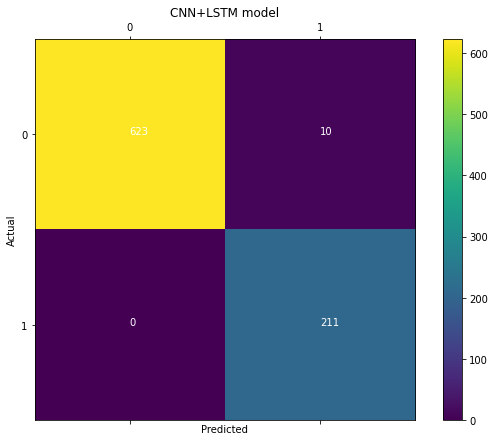


 [633 211]
teacher_accuracy
0.9881516695022583
teacher_specificity
0.9842022116903634
teacher_sensitivity
1.0
teacher_precision
0.9547511312217195
teacher_recall
1.0
teacher_frr
0.0
teacher_far
0.01579778830963665


In [15]:
# Train teacher as usual # 평소와 같은 방법으로 교사모델 훈련시작
teacher.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer = tf.keras.optimizers.Adam(0.0008547152588812913),
    metrics=[keras.metrics.BinaryAccuracy()],
)

teacher.summary()

# Train and evaluate teacher on data. # 데이터셋을 통해 교사의 트레인 및 평가
hist = teacher.fit(x_train, y_train, batch_size=20, epochs=100, verbose = 1)

# save model
teacher.save('Teacher_Model_10.h5')

teacher_loss, teacher_acc = teacher.evaluate(x_test, y_test, verbose = 2)
teacher_pred = teacher.predict(x_test)
    
# 확률이 0.5이상이면 자신(1), 작으면 타인(0)
for i in range(len(teacher_pred)):
    if(0.5 <= teacher_pred[i]):
        teacher_pred[i] = 1

    else:
        teacher_pred[i] = 0
        
# confusion matrix 생성
conf_matrix = confusion_matrix(y_test, teacher_pred)
    
#############################################################
#       conf_matrix[0][0] = TN      conf_matrix[0][1] = FP  #
#       conf_matrix[1][0] = FN      conf_matrix[1][1] = TP  #
#############################################################

print(conf_matrix)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

cax = ax.matshow(conf_matrix)

fig.colorbar(cax)

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], color="white")

plt.title('CNN+LSTM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

# sum 이용 각 행 더하기
row = conf_matrix.sum(axis=1)
print('\n', row)

conf_row = conf_matrix.sum(axis = 1)
conf_col = conf_matrix.sum(axis = 0)

# row[0] = spec의 분모, row[1] = sens의 분모

teacher_sen = conf_matrix[1][1] / row[1]
teacher_spe = conf_matrix[0][0] / row[0]
    
teacher_frr = conf_matrix[1][0] / (conf_matrix[1][1]+conf_matrix[1][0])
teacher_far = conf_matrix[0][1] / (conf_matrix[0][1]+conf_matrix[0][0])
    
teacher_prec = conf_matrix[1][1] / conf_col[1]
teacher_recall = conf_matrix[1][1] / conf_row[1]
    
print('teacher_accuracy')
print(teacher_acc)
print('teacher_specificity')
print(teacher_spe)
print('teacher_sensitivity')
print(teacher_sen)
print('teacher_precision')
print(teacher_prec)
print('teacher_recall')
print(teacher_recall)
print('teacher_frr')
print(teacher_frr)
print('teacher_far')
print(teacher_far)

Epoch 1/100
211/211 [==============================] - 4s 20ms/step - binary_accuracy: 0.7602 - student_loss: 0.4880 - distillation_loss: 0.0000e+00
Epoch 2/100
211/211 [==============================] - 4s 19ms/step - binary_accuracy: 0.8505 - student_loss: 0.3274 - distillation_loss: 0.0000e+00
Epoch 3/100
211/211 [==============================] - 4s 18ms/step - binary_accuracy: 0.8836 - student_loss: 0.2807 - distillation_loss: 0.0000e+00
Epoch 4/100
211/211 [==============================] - 4s 18ms/step - binary_accuracy: 0.9163 - student_loss: 0.2071 - distillation_loss: 0.0000e+00
Epoch 5/100
211/211 [==============================] - 4s 19ms/step - binary_accuracy: 0.9337 - student_loss: 0.1621 - distillation_loss: 0.0000e+00
Epoch 6/100
211/211 [==============================] - 4s 19ms/step - binary_accuracy: 0.9503 - student_loss: 0.1408 - distillation_loss: 0.0000e+00
Epoch 7/100
211/211 [==============================] - 4s 19ms/step - binary_accuracy: 0.9518 - student_lo

211/211 [==============================] - 4s 19ms/step - binary_accuracy: 0.9834 - student_loss: 0.0472 - distillation_loss: 0.0000e+00
Epoch 56/100
211/211 [==============================] - 4s 19ms/step - binary_accuracy: 0.9829 - student_loss: 0.0545 - distillation_loss: 0.0000e+00
Epoch 57/100
211/211 [==============================] - 4s 19ms/step - binary_accuracy: 0.9800 - student_loss: 0.0529 - distillation_loss: 0.0000e+00
Epoch 58/100
211/211 [==============================] - 4s 19ms/step - binary_accuracy: 0.9827 - student_loss: 0.0503 - distillation_loss: 0.0000e+00
Epoch 59/100
211/211 [==============================] - 4s 19ms/step - binary_accuracy: 0.9831 - student_loss: 0.0523 - distillation_loss: 0.0000e+00
Epoch 60/100
211/211 [==============================] - 4s 19ms/step - binary_accuracy: 0.9829 - student_loss: 0.0523 - distillation_loss: 0.0000e+00
Epoch 61/100
211/211 [==============================] - 4s 19ms/step - binary_accuracy: 0.9791 - student_loss: 0.

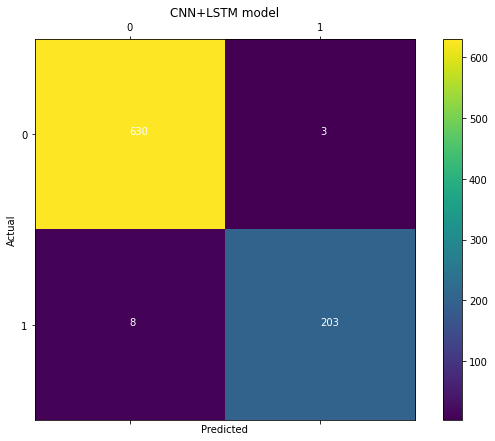


 [633 211]
student_accuracy
0.9869668483734131
student_specificity
0.995260663507109
student_sensitivity
0.9620853080568721
student_precision
0.9854368932038835
student_recall
0.9620853080568721
student_frr
0.037914691943127965
student_far
0.004739336492890996


In [16]:
# Initialize and compile distiller
distiller = Distiller(student=student, teacher=teacher)
  
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.BinaryAccuracy()],
    student_loss_fn=keras.losses.BinaryCrossentropy(from_logits=False),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
distiller.fit(x_train, y_train, batch_size=20, epochs=100, verbose = 1)

# save model
student.save('Student_Model_10.h5')

# Evaluate student on test dataset
student_acc = distiller.evaluate(x_test, y_test, verbose = 2)
student_pred = student.predict(x_test)
    
# 확률이 0.5이상이면 자신(1), 작으면 타인(0)
for i in range(len(student_pred)):
    if(0.5 <= student_pred[i]):
        student_pred[i] = 1

    else:
        student_pred[i] = 0
        
# confusion matrix 생성
conf_matrix = confusion_matrix(y_test, student_pred)
    
#############################################################
#       conf_matrix[0][0] = TN      conf_matrix[0][1] = FP  #
#       conf_matrix[1][0] = FN      conf_matrix[1][1] = TP  #
#############################################################

print(conf_matrix)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

cax = ax.matshow(conf_matrix)

fig.colorbar(cax)

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], color="white")

plt.title('CNN+LSTM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

# sum 이용 각 행 더하기
row = conf_matrix.sum(axis=1)
print('\n', row)

conf_row = conf_matrix.sum(axis = 1)
conf_col = conf_matrix.sum(axis = 0)

# row[0] = spec의 분모, row[1] = sens의 분모

student_sen = conf_matrix[1][1] / row[1]
student_spe = conf_matrix[0][0] / row[0]
    
student_frr = conf_matrix[1][0] / (conf_matrix[1][1]+conf_matrix[1][0])
student_far = conf_matrix[0][1] / (conf_matrix[0][1]+conf_matrix[0][0])
    
student_prec = conf_matrix[1][1] / conf_col[1]
student_recall = conf_matrix[1][1] / conf_row[1]

print('student_accuracy')
print(student_acc)
print('student_specificity')
print(student_spe)
print('student_sensitivity')
print(student_sen)
print('student_precision')
print(student_prec)
print('student_recall')
print(student_recall)
print('student_frr')
print(student_frr)
print('student_far')
print(student_far)

In [17]:
import tempfile

# gzip을 통해 모델을 실제로 압축하고 압축된 크기를 측정
# 모델의 크기(바이트)를 반환한다.
def get_gzipped_model_size(file):
  
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [18]:
# 임시 파일을 생성하고 그 파일에 학습한 모델을 저장한다.
# keras_file는 file path
_, teacher_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(teacher, teacher_file, include_optimizer=False)
print('Saved teacher model to:', teacher_file)

# 임시 파일을 생성하고 그 파일에 학습한 모델을 저장한다.
# keras_file는 file path
_, student_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(student, student_file, include_optimizer=False)
print('Saved student model to:', student_file)

print("Size of gzipped Teacher model: %.2f bytes" % (get_gzipped_model_size(teacher_file)))
print("Size of gzipped Student model: %.2f bytes" % (get_gzipped_model_size(student_file)))

Saved teacher model to: /tmp/tmpha_5riqx.h5
Saved student model to: /tmp/tmpyodhymty.h5
Size of gzipped Teacher model: 770209.00 bytes
Size of gzipped Student model: 13732.00 bytes
